# Exercise 4: Short-time Fourier Transform

Doing this exercise you will learn about the concept of the main lobe width of the spectrum of a window and you will better understand the short-time Fourier transform (STFT). You will also use the STFT to extract basic rhythm related information from an audio signal, implementing an onset detection function, which is one of the rhythm descriptors often used in music information retrieval to detect onsets of acoustic events. 

There are four parts in this exercise. 1) Extracting the main lobe of the spectrum of a window, 2) Measuring noise in the reconstructed signal using the STFT model, 3) Computing band-wise energy envelopes of a signal, 4) Computing an onset detection function.


### Relevant Concepts

__Main lobe of the spectrum of a window:__
The width of the main lobe of the magnitude spectrum of a window is an important characteristic used in deciding which window type is best for the analysis of an audio excerpt. There exists a tradeoff between the main lobe width and the side lobe attenuation. Typically for windows with a narrower main lobe, the side lobes are less attenuated. 
An interesting fact is that changing the length of a window $M$ doesn't affect the main lobe width of the spectrum of the window in samples. Note that if you use zero-padding for computing the spectrum of a window, the main lobe width will be multiplied by the zero-padding factor.

__Fast Fourier Transform (FFT):__
An efficient way to compute the discrete Fourier transform of a signal is the fast Fourier transform, FFT. The FFT algorithm  factorizes the DFT matrix in order to exploit the symmetries in the DFT equation. FFT computation is specially very efficient when the FFT size is a power of 2. Therefore, whenever possible we use an FFT size that is a power of 2.

__Energy of a signal:__ The energy of a signal $x[n]$ of length $N$ can be computed in the discrete time domain as follows:
\begin{equation}
E=\overset{N-1}{\underset{n=0}{\sum}}\left|x\left[n\right]\right|^{2}
\end{equation}

__Energy in a frequency band:__ Given the DFT spectrum of the signal $X[k]$, the energy $E$ in a specific frequency band spanning the bin index $k_1$ to $k_2$ can be computed as:

\begin{equation}
E=\overset{k_{2}}{\underset{k=k_{1}}{\sum}}\left|X\left[k\right]\right|^{2}
\end{equation}

Note that in this computation the $X[k]$ values are not in decibels (dB). The `stftAnal()` function returns magnitude spectra in dB scale, which should be converted to linear scale before the energy computation. Once the energy is computed it can be converted back to the dB scale as:

\begin{equation}
E_{dB}= 10\,\log_{10}(E)
\end{equation}

__Signal to noise ratio (SNR):__
Signal to noise ratio (SNR) is a frequently used measure to quantify the amount of noise present/added in a signal. In the context of this exercise it can be computed in decibels (dB) as:

\begin{equation}
\mathrm{SNR} = 10\,\log_{10}\left(\frac{E_{\mathrm{signal}}}{E_{\mathrm{noise}}}\right)
\end{equation}

where, $E_{\mathrm{signal}}$ and $E_{\mathrm{noise}}$ are the energy of the signal and noise respectively.

For our case of analysis and synthesis using a specific model (for example, STFT) noise can be thought of as the difference between the input signal and the output signal of the model.

__Onset detection function:__
An onset detection function (ODF) refers to a continuous function (one value per audio frame) often used for detecting acoustic events in an audio stream. In music information retrieval (MIR), ODFs are typically used for detecting onsets of musical notes and percussion strokes. An ODF generally has high values at the onsets of acoustic events. A simple ODF can be computed by taking the difference between the energy values of consecutive frames, as shown below:

\begin{equation}
O(l) = E(l) - E(l-1) ,\,\,\,\,\, l \geq 1
\end{equation}

where, $O(l)$ is the ODF computed at frame index $l$ and $E$ is the energy of the signal in a particular frequency band in decibels (dB). Often, multiple ODFs are computed with different frequency bands across the spectrum. 

In order to detect only the onsets of the events and not the offsets, it is a common practice to half wave rectify the ODF and obtain $\bar{O}(l)$. Half wave rectification of the ODF is given by:

 \begin{equation}
 \bar{O}(l)=\begin{cases}
 \begin{array}{c}
 O(l), \, \mathrm{if} \,\,O(l)>0\\
 \,\,\,\,0, \,\,\,\,\, \mathrm{if} \,\, O(l)\leq0
 \end{array}\end{cases} 
 \end{equation}

## Part 1 - Extracting the main lobe of the spectrum of a window

Complete the function `extract_main_lobe()` to extract the main lobe of the magnitude spectrum of a window given a window type, `window`, and its length, `M`. The function should return the samples corresponding to the main lobe in decibels (dB).

To compute the spectrum, take the FFT size (`N`) to be 8 times the window length (`N = 8*M`) (For this part, `N` does not need to be a power of 2). 

The input arguments to the function are the window type (`window`) and the length of the window (`M`). The function should return a numpy array containing the samples corresponding to the main lobe of the window. In the returned numpy array you should include the samples corresponding to both the local minimas across the main lobe. 

The possible window types that you can expect as input are rectangular (`'boxcar'`), `'hamming'` or `'blackmanharris'`.

NOTE: You can approach this question by writing code to find the indices of the local minimas across the main lobe.

_Tip:_ `log10(0)` is not well defined, so its a common practice to add a small value such as `eps = 1e-16` 
to the magnitude spectrum before computing it in dB. This is optional and will not affect your answers. 
If you find it difficult to concatenate the two halves of the main lobe, you can first center the 
spectrum using `fftshift()` and then compute the indexes of the minimas around the main lobe.

In [1]:
import os
import sys
import numpy as np

from scipy.signal import get_window
from scipy.fftpack import fft, fftshift

import math
import matplotlib.pyplot as plt
#%matplotlib notebook
eps = np.finfo(float).eps

sys.path.append('../software/models/')
import stft
import utilFunctions as UF

In [2]:
def extract_main_lobe(window, M):
    """
    Input:
            window (string): Window type to be used (Either rectangular ('boxcar'), 'hamming' or '
                blackmanharris')
            M (integer): length of the window to be used
    Output:
            a numpy array containing the main lobe of the magnitude spectrum of the window in decibels (dB).
    """

    w = get_window(window, M)         # get the window 
    
    ### Your code here
    N = M*8
    X = fft(w, N)
    X = fftshift(X) + eps
    
    min_after = np.diff( np.sign( np.diff( abs( X[(N//2):] ) ) ) ).nonzero()[0][0] + 1 # first local min+max after N//2 index
    min_before = np.diff( np.sign( np.diff( abs( X[(N//2)::-1] ) ) ) ).nonzero()[0][0] + 1 # first local min+max before N//2 index
    
    main_lobe = X[ (N//2) - min_before : (N//2) + min_after + 1]
    
    return 20*np.log10(abs(main_lobe))

Now run and test the `extract_main_lobe()` function. Here you have 3 test cases:

_Test case 1:_ If you run your code using `window = 'blackmanharris'` and `M = 100`, the output numpy 
array should contain 65 samples.

_Test case 2:_ If you run your code using `window = 'boxcar'` and `M = 120`, the output numpy array 
should contain 17 samples.

_Test case 3:_ If you run your code using `window = 'hamming'` and `M = 256`, the output numpy array 
should contain 33 samples.

To understand better the result you can plot the magnitude spectrum of the window and mark the boundaries of the main lobe.

Window: blackman
Number of samples of the main lobe: 49
Width of the main lobe: 6


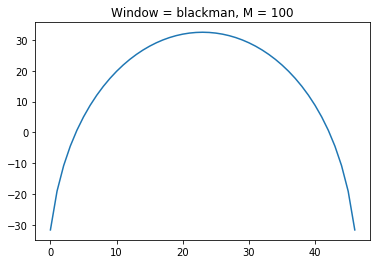

Window: boxcar
Number of samples of the main lobe: 17
Width of the main lobe: 2


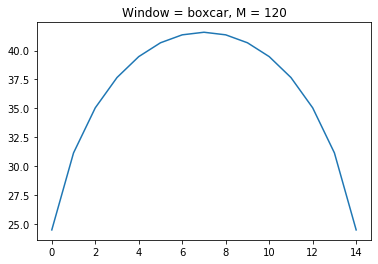

Window: hamming
Number of samples of the main lobe: 33
Width of the main lobe: 4


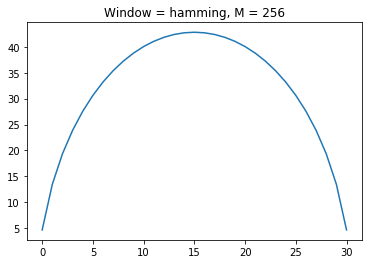

In [3]:
## Your code here
from scipy.signal import find_peaks
def test_case(w, M):
    main_lobe = extract_main_lobe(w, M)
    zpf = 8 # zero-padding factor
    print("Window:", w)
    print("Number of samples of the main lobe:", len(main_lobe) )
    print("Width of the main lobe:", int( (len(main_lobe)-1) / zpf ) )
    
    # plotting
    plt.plot( main_lobe[ 1:len(main_lobe)-1 ] )
    plt.title( "Window = {}, M = {}".format(w, M) )
    plt.show()

# Test case 1
test_case("blackmanharris",100)

# Test case 2
test_case("boxcar",120)

# Test case 3
test_case("hamming",256)

## Part 2 - Measuring noise in the reconstructed signal using the STFT model 

Complete the function `compute_snr()` to measure the amount of noise introduced during the analysis and synthesis of a signal using the STFT model. Use SNR (signal to noise ratio) in dB to quantify the amount of noise. 
Use the `stft()` function in `stft.py` to do an analysis followed by a synthesis of the input signal.

Use the time domain energy definition to compute the SNR. With the input signal and the obtained output, compute two different SNR values for the following cases:

1. `SNR1`: Over the entire length of the input and the output signals.
2. `SNR2`: For the segment of the signals left after discarding `M` samples from both the start and the end, where `M` is the analysis window length. 

Note that the computations are done after STFT analysis and synthesis. The input arguments to the function are the wav file name including the path (`input_file`), window  type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a python tuple of both the SNR values in decibels. Both SNR1 and SNR2 are float values. 

In [4]:
def compute_snr(input_file, window, M, N, H):
    """
    Input:
            input_file (string): wav file name including the path 
            window (string): analysis window type (choice of rectangular, triangular, hanning, hamming, 
                    blackman, blackmanharris)
            M (integer): analysis window length (odd positive integer)
            N (integer): fft size (power of two, > M)
            H (integer): hop size for the stft computation
    Output:
            tuple with the signal to noise ratio over the whole sound and of the sound without the begining and end.
    """
    ## your code here
    fs, x = UF.wavread(input_file)
    w = get_window(window, M)
    y = stft.stft(x, w, N, H)
    
    E_y1 = y @ y
    E_y2 = y[M:len(y)-M] @ y[M:len(y)-M] # discarding M samples from both the start and the end
    
    noise1 = x - y # noise as the difference between the input signal and the output signal of the model
    noise2 = x[M:len(x)-M] - y[M:len(y)-M]
    
    E_noise1 = noise1 @ noise1 
    E_noise2 = noise2 @ noise2
    
    SNR1 = 10 * np.log10( E_y1 / E_noise1 )
    SNR2 = 10 * np.log10( E_y2 / E_noise2 )
    
    return (SNR1, SNR2)

Now run and test `compute_snr()`. Use the following test cases to check your code.

_Test case 1:_ If you run your code using `piano.wav` file with `'blackman'` window, `M = 513`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(67.57748352378475, 304.68394693221649)`.

_Test case 2:_ If you run your code using `sax-phrase-short.wav` file with `'hamming'` window, `M = 512`, 
`N = 1024` and `H = 64`, the output SNR values should be around: `(89.510506656299285, 306.18696700251388)`.

_Test case 3:_ If you run your code using `rain.wav` file with `'hann'` window, `M = 1024`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(74.631476225366825, 304.26918192997738)`.

Due to precision differences on different machines/hardware, compared to the expected SNR values, your 
output values can differ by +/-10dB for `SNR1` and +/-100dB for `SNR2`.

In [11]:
## Your code here
# Test case 1
print("Test case 1")
print( compute_snr("../sounds/piano.wav", "blackman", 513, 2048, 171), "\n" )

# Test case 2
print("Test case 2")
print( compute_snr("../sounds/sax-phrase-short.wav", "hamming", 512, 1024, 64), "\n" )

# Test case 3
print("Test case 3")
print( compute_snr("../sounds/rain.wav", "hann", 1024, 2048, 128), "\n" )

Test case 1
(68.44291795260152, 309.388081698243) 

Test case 2
(89.51050658647432, 306.2047042780217) 

Test case 3
(74.63147348974444, 305.41401050127564) 



## Part 3 - Computing band-wise energy envelopes of a signal

Complete the function `compute_eng_env()` to compute band-wise energy envelopes of a given audio signal using the STFT.

Consider two frequency bands, low and high. The low frequency band is the set of frequencies between 0 and 3000 Hz and the high frequency band is the set of frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). At a given frame, the value of the energy envelope of a band can be computed as the sum of squared values of all the frequency coefficients in that band. Then you should compute the energy envelopes in decibels. 

The input arguments are the wav file name including the path (`input_file`), window type (`window`), window length (`M`), FFT size (`N`) and hop size (`H`). The function should return a numpy array with two columns, where the first column is the energy envelope of the low frequency band and the second column is that of the high frequency band.

Use `stftAnal()` function from `stft.py` module to obtain the magnitude spectra for all the audio frames of the input sound. Then compute the energy values for each frequency band specified. While calculating frequency bins for each frequency band, consider only the bins that are within the specified frequency range. For example, for the low frequency band consider only the bins with frequency > 0 Hz and < 3000 Hz (you can use `np.where()` to find those bin indexes). This way you also remove the DC offset of the signal in energy envelope computation. The frequency corresponding to the bin index `k` can be computed as `k*fs/N`, where `fs` is the sampling rate of the signal.

In [6]:
def compute_eng_env(input_file, window, M, N, H):
    """
    Inputs:
            input_file (string): input sound file (monophonic with sampling rate of 44100)
            window (string): analysis window type (choice of rectangular, triangular, hanning, 
                hamming, blackman, blackmanharris)
            M (integer): analysis window size (odd positive integer)
            N (integer): FFT size (power of 2, such that N > M)
            H (integer): hop size for the stft computation
    Output:
            magnitude spectra of sound (2D array)
            2D numpy array with energy envelope of band 0 < f < 3000 Hz (in dB) in first column, [:,0] and 
            energy envelope of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here
    fs, x = UF.wavread(input_file)
    w = get_window(window, M)
    
    f = np.arange(N/2+1)*float(fs)/N #frequency index
    idx_0_3K = np.where( ( f > 0 ) & ( f < 3000 ) ) # low frequency band
    idx_3K_10K = np.where( ( f > 3000 ) & ( f < 10000 ) ) # high frequency band
    
    xmX, xpX = stft.stftAnal(x, w, N, H) #stft
    
    energy_envelope = []
    for mX in xmX:
        E_0_3K = 10**(mX[idx_0_3K]/20) @ 10**(mX[idx_0_3K]/20) # energy of the low band
        E_3K_10K = 10**(mX[idx_3K_10K]/20) @ 10**(mX[idx_3K_10K]/20) # energy of the high band
        E_0_3K_dB = 10 * np.log10 ( E_0_3K ) # denormalize energy of the low band in dB
        E_3K_10K_dB = 10 * np.log10 ( E_3K_10K ) # denormalize energy of the high band in dB
        energy_envelope.append( [ E_0_3K_dB, E_3K_10K_dB ]  ) # energy envelope
    energy_envelope = np.array(energy_envelope)

    low_range = ( idx_0_3K[0][0], idx_0_3K[0][-1] ) # low frequency bin range
    high_range = ( idx_3K_10K[0][0], idx_3K_10K[0][-1] ) # high frequency bin range 
    
    return xmX, energy_envelope, low_range, high_range

Now run and test `compute_eng_env()`. In order to check it you can run and compare these 3 test cases, ploting the results.

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples).

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples).

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the band-wise energy envelope and its characteristics you can plot the envelopes together with the spectrogram of the signal. You can use `matplotlib` plotting library for this purpose. To visualize the spectrogram of a signal, a good option is to use the function `colormesh()` (you can reuse the code in
`lectures/4-STFT/plots-code/spectrogram.py`). Either overlay the envelopes on the spectrogram 
or plot them in a different subplot. Make sure you use the same range of the x-axis for both the spectrogram and the energy envelopes.

You can clearly notice the sharp attacks and decay of the piano notes for test case 1. You can compare this with the output from test case 2 that uses a larger window. You can infer the influence of window size on sharpness of the note attacks.

Low frequency bin range: (1, 69)
High frequency bin range: (70, 232) 



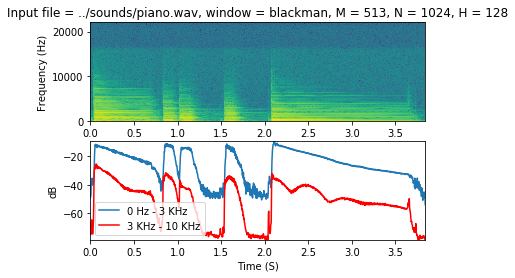

Low frequency bin range: (1, 278)
High frequency bin range: (279, 928) 



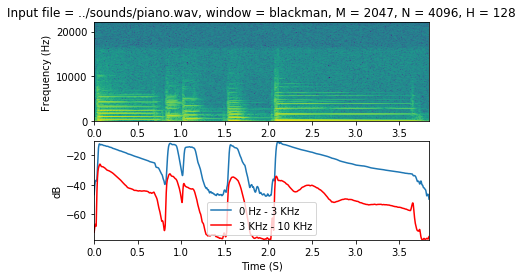

Low frequency bin range: (1, 139)
High frequency bin range: (140, 464) 



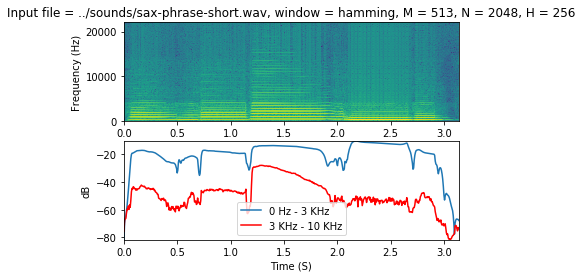

In [7]:
## Your code here
fs = 44100
#function for test cases
def test_case(input_file, window, M, N, H):
    mX, energy_envelope, low_range, high_range = compute_eng_env(input_file, window, M, N, H)

    # ranges
    print("Low frequency bin range:", low_range)
    print("High frequency bin range:", high_range, "\n")
    
    # plotting - code from lectures/4-STFT/plots-code/spectrogram.py
    plt.subplot(211)
    numFrames = int(mX[:,0].size)
    frmTime = H*np.arange(numFrames)/float(fs)
    binFreq = np.arange(N/2+1)*float(fs)/N
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX)) 
    plt.ylabel("Frequency (Hz)")
    plt.title( "Input file = {}, window = {}, M = {}, N = {}, H = {}".format( input_file, window, M, N, H ) )
    plt.autoscale(tight=True)
    
    plt.subplot(212)
    plt.plot(frmTime, energy_envelope[:,0], label="0 Hz - 3 KHz" )
    plt.plot(frmTime, energy_envelope[:,1], 'r', label="3 KHz - 10 KHz")
    plt.xlabel("Time (S)")
    plt.ylabel("dB")
    plt.legend()
    plt.autoscale(tight=True)
    plt.show()

# Test case 1
test_case( "../sounds/piano.wav", "blackman", 513, 1024, 128 )

# Test case 2
test_case( "../sounds/piano.wav", "blackman", 2047, 4096, 128 )

# Test case 3
test_case( "../sounds/sax-phrase-short.wav", "hamming", 513, 2048, 256 )


## Part 4 - Computing onset detection function

Complete the function `compute_odf()` to compute a simple onset detection function (ODF) using the STFT. Compute two ODFs one for each of the frequency bands, low and high. The low frequency band is the set of all the frequencies between 0 and 3000 Hz and the high frequency band is the set of all the frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). 

Start with an initial condition of `ODF(0) = 0` in order to make the length of the ODF same as that of the energy envelope. Remember to apply a half wave rectification on the ODF. 

The input arguments to the function are the wav file name including the path (`input_file`), window 
type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a numpy 
array with two columns, where the first column is the ODF computed on the low frequency band and the 
second column is the ODF computed on the high frequency band.

Use `stftAnal()` to obtain the magnitude spectra for all the audio frames. Then compute the band-wise energy envelope for each frequency band specified. Finally compute the half wave rectify version of ODF from each energy envelope.


In [8]:
def compute_odf(input_file, window, M, N, H):
    """
    Inputs:
            input_file (string): input sound file (monophonic with sampling rate of 44100)
            window (string): analysis window type (choice of rectangular, triangular, hanning, hamming, 
                blackman, blackmanharris)
            M (integer): analysis window size (odd integer value)
            N (integer): fft size (power of two, bigger or equal than than M)
            H (integer): hop size for the STFT computation
    Output:
            magnitude spectra of sound (2D array)
            2D numpy array with ODF computed in band 0 < f < 3000 Hz (in dB) in first column, [:,0] and 
            ODF computed of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here
    xmX, energy_envelope, low_range, high_range = compute_eng_env(input_file, window, M, N, H) # part 3 of this assignment
    
    E_diff = np.diff( energy_envelope, axis = 0 ) + 0 # difference along each band
    E_diff[ np.where( E_diff < 0 ) ] = 0 # half wave rectification
    
    ODF = np.array( [[0,0]] ) # initial condition
    ODF = np.append(ODF, E_diff, axis = 0)
    
    return xmX, ODF, low_range, high_range

Now run and test `compute_odf()`. In order to check it you can run and compare these 3 test cases. Plot the results.

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples). 

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples). 

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the ODFs and their characteristics you can plot the ODF functions together with the spectrogram of the signal. Use the same plotting than in the previos part.

In order to identify the actual onsets of a signal you would need to find the peaks, local maxima, of the ODF functions using a magnitude threshold. Which of the 2 ODFs would be most useful? What would be the right threshold for all 3 cases? Could you find a single threshold to be used for all 3 cases?

For test case 1, you should clearly see that the ODFs have sharp peaks at the onset of the piano notes. You should notice 5 peaks that are above 10dB value in the ODF computed on the high frequency band. 

Low frequency bin range: (1, 69)
High frequency bin range: (70, 232) 



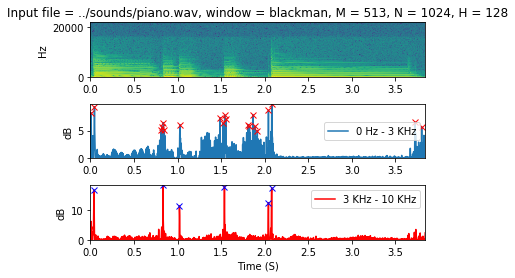

Low frequency bin range: (1, 278)
High frequency bin range: (279, 928) 



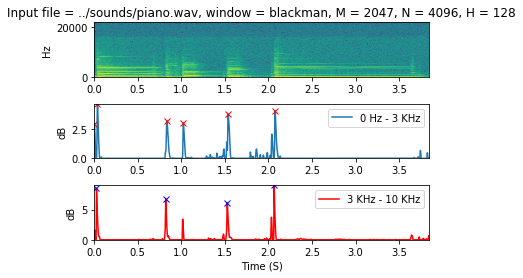

Low frequency bin range: (1, 139)
High frequency bin range: (140, 464) 



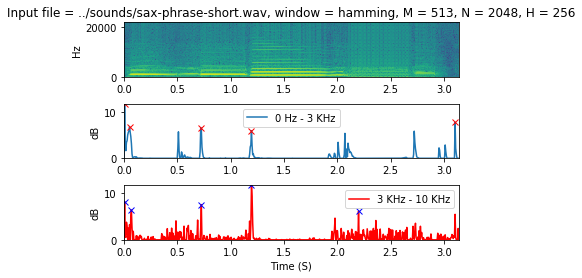

In [10]:
## Your code here
from scipy.signal import find_peaks
fs = 44100
#function for test cases
def test_case(input_file, window, M, N, H):
    mX, ODF, low_range, high_range = compute_odf(input_file, window, M, N, H)

    # ranges
    print("Low frequency bin range:", low_range)
    print("High frequency bin range:", high_range, "\n")
    
    # plotting - code from lectures/4-STFT/plots-code/spectrogram.py
    plt.subplot(311)
    plt.subplots_adjust(hspace = .5)
    numFrames = int(mX[:,0].size)
    frmTime = H*np.arange(numFrames)/float(fs)
    binFreq = np.arange(N/2+1)*float(fs)/N
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX)) 
    plt.ylabel("Hz")
    plt.title( "Input file = {}, window = {}, M = {}, N = {}, H = {}".format( input_file, window, M, N,H ) )
    plt.autoscale(tight=True)
    
    plt.subplot(312)
    plt.plot(frmTime, ODF[:,0], label="0 Hz - 3 KHz" )
    idx_peaks = find_peaks( ODF[:,0]/np.max(ODF[:,0]), height=0.5)[0] # index peaks
    plt.plot( H*idx_peaks/float(fs), ODF[idx_peaks,0], linestyle='None', marker='x', color='r' ) # plotting peaks
    plt.ylabel("dB")
    plt.legend()
    plt.autoscale(tight=True)
    
    plt.subplot(313)
    plt.plot(frmTime, ODF[:,1], 'r', label="3 KHz - 10 KHz")
    idx_peaks = find_peaks( ODF[:,1]/np.max(ODF[:,1]), height=0.5)[0] # index peaks
    plt.plot( H*idx_peaks/float(fs), ODF[idx_peaks,1], linestyle='None', marker='x', color='b' ) # plotting peaks
    plt.xlabel("Time (S)")
    plt.ylabel("dB")
    plt.legend()
    plt.autoscale(tight=True)
    plt.show()
    
# Test case 1
test_case( "../sounds/piano.wav", "blackman", 513, 1024, 128 )

# Test case 2
test_case( "../sounds/piano.wav", "blackman", 2047, 4096, 128 )

# Test case 3
test_case( "../sounds/sax-phrase-short.wav", "hamming", 513, 2048, 256 )

## Your explanation of Part 4 here

#### Which of the 2 ODFs would be most useful?
This depends on the parameters used in the STFT and the harmonic characteristics of the sound. The STFT parameters introduce a trade-off between time and frequency resolutions, that is to say, we cannot arbitrarily narrow our focus both in time and frequency. If we want a higher time resolution we will necessarily have to give up frequency resolution and vice versa (uncertainty principle in time frequency analysis).

In case 1, the piano sound is tested with a shorter window size compared to that in case 2, so the time resolution is better, but the due to the fact that the frequency resolution is lower in case 1, the low band ODF is not as good as the high band ODF where harmonics are more separated. So in case 1 the high band ODF is more useful.

In case 2, the piano sound is tested with a larger window size compared to that in case 1, so frequency resolution is better. Both ODFs offers a good onset estimate, been the low band slightly better for this piano sound.

In case 3, the penultimate note describes a significantly long attack time as can be heard in the sound file, making it difficult for onset detection even with a short window.

#### What would be the right threshold for all 3 cases? - Could you find a single threshold to be used for all 3 cases?
From the test case plots, we can show that the ODFs ranges vary with the parameter settings of the STFT and with the harmonic characteristics of the sound, so with the approach used here we could not find a single threshold to be used for all these cases.

The markers used in the plots were computed using a threshold as the half of the maximum peak in the respective ODF. This offers a not so bad estimate, but that clearly fails in many cases.